In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics 

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Cobify_clean_data.csv')
data.head()

,distance,consume,temp_inside,temp_outside,gas_type,ac,rain,sun,temp_diff,fuel_used,cost_of_trip,trip_in_hours,avg_speed
0,28.0,5.0,21.5,12,E10,0,0,0,9.5,1.4000,2.863,0.433333,64.615385
1,12.0,4.2,21.5,13,E10,0,0,0,8.5,0.5040,1.031,0.500000,24.000000
2,11.2,5.5,21.5,15,E10,0,0,0,6.5,0.6160,1.260,0.633333,17.684211
3,12.9,3.9,21.5,14,E10,0,0,0,7.5,0.5031,1.029,0.600000,21.500000
4,18.5,4.5,21.5,15,E10,0,0,0,6.5,0.8325,1.702,0.766667,24.130435


In [3]:
correlations = data.corr()
correlations

,distance,consume,temp_inside,temp_outside,ac,rain,sun,temp_diff,fuel_used,cost_of_trip,trip_in_hours,avg_speed
distance,1.000000,-0.128967,0.077636,0.088175,-0.025738,-0.019791,0.081120,-0.080453,0.992101,0.990944,0.562299,0.884942
consume,-0.128967,1.000000,-0.154953,-0.320811,0.096591,0.248118,-0.170667,0.311697,-0.052188,-0.051965,-0.227866,-0.177825
temp_inside,0.077636,-0.154953,1.000000,0.357431,0.300407,-0.035199,0.241530,-0.224108,0.065359,0.064781,0.060039,0.069588
temp_outside,0.088175,-0.320811,0.357431,1.000000,0.167562,-0.186315,0.346903,-0.990287,0.037877,0.040100,0.015411,0.107179
ac,-0.025738,0.096591,0.300407,0.167562,1.000000,0.242915,0.088598,-0.130129,-0.018700,-0.017403,-0.035408,-0.009260
rain,-0.019791,0.248118,-0.035199,-0.186315,0.242915,1.000000,-0.112650,0.189179,0.009125,0.011388,0.009489,-0.027300
sun,0.081120,-0.170667,0.241530,0.346903,0.088598,-0.112650,1.000000,-0.326036,0.064247,0.065632,0.081618,0.058150
temp_diff,-0.080453,0.311697,-0.224108,-0.990287,-0.130129,0.189179,-0.326036,1.000000,-0.029795,-0.032200,-0.007143,-0.101481
fuel_used,0.992101,-0.052188,0.065359,0.037877,-0.018700,0.009125,0.064247,-0.029795,1.000000,0.999497,0.551847,0.868658
cost_of_trip,0.990944,-0.051965,0.064781,0.040100,-0.017403,0.011388,0.065632,-0.032200,0.999497,1.000000,0.546884,0.867029


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

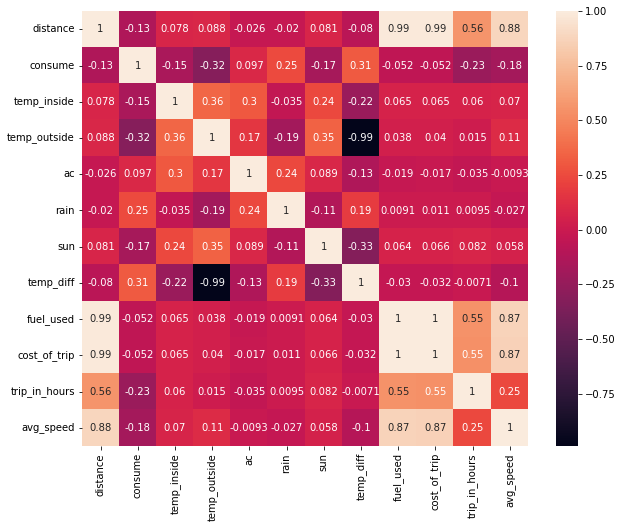

In [4]:
fig, ax=plt.subplots(figsize=(10,8))
ax=sns.heatmap(correlations, annot=True)
plt.show()

### Because of the multi-collinearity I will drop the columns that I created

In [5]:
cols_to_drop = ['temp_diff','cost_of_trip','fuel_used','avg_speed']
data=data.drop(cols_to_drop,axis=1)
data

,distance,consume,temp_inside,temp_outside,gas_type,ac,rain,sun,trip_in_hours
0,28.0,5.0,21.5,12,E10,0,0,0,0.433333
1,12.0,4.2,21.5,13,E10,0,0,0,0.500000
2,11.2,5.5,21.5,15,E10,0,0,0,0.633333
3,12.9,3.9,21.5,14,E10,0,0,0,0.600000
4,18.5,4.5,21.5,15,E10,0,0,0,0.766667
...,...,...,...,...,...,...,...,...,...
383,16.0,3.7,24.5,18,SP98,0,0,0,0.650000
384,16.1,4.3,25.0,31,SP98,1,0,0,0.633333
385,16.0,3.8,25.0,19,SP98,0,0,0,0.750000
386,15.4,4.6,25.0,31,SP98,1,0,0,0.700000


### Splitting into X-features and y-target.  We are trying to predict the amount of fuel consumed.

In [6]:
X = data.drop('consume',axis=1)
y = data['consume']
X

,distance,temp_inside,temp_outside,gas_type,ac,rain,sun,trip_in_hours
0,28.0,21.5,12,E10,0,0,0,0.433333
1,12.0,21.5,13,E10,0,0,0,0.500000
2,11.2,21.5,15,E10,0,0,0,0.633333
3,12.9,21.5,14,E10,0,0,0,0.600000
4,18.5,21.5,15,E10,0,0,0,0.766667
...,...,...,...,...,...,...,...,...
383,16.0,24.5,18,SP98,0,0,0,0.650000
384,16.1,25.0,31,SP98,1,0,0,0.633333
385,16.0,25.0,19,SP98,0,0,0,0.750000
386,15.4,25.0,31,SP98,1,0,0,0.700000


### Splitting into Training and Testing Data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
print('X_train shape is:',X_train.shape)
print('y_train shape is:', y_train.shape)
print('X_test shape is:', X_test.shape)
print('y_train shape is:', y_test.shape)

<IPython.core.display.Javascript object>

X_train shape is: (310, 8)
y_train shape is: (310,)
X_test shape is: (78, 8)
y_train shape is: (78,)


In [8]:
X_train_num = X_train.select_dtypes(np.number)
X_train_cat = X_train.select_dtypes(object)
X_test_num = X_test.select_dtypes(np.number)
X_test_cat = X_test.select_dtypes(object)

### Here we will transform and scale our numerical data

In [9]:
transformer = MinMaxScaler().fit(X_train_num)
# only transforming on the Train data
X_train_norm = transformer.transform(X_train_num)
print(X_train_norm.shape)
X_train_num_scale = pd.DataFrame(X_train_norm, index = X_train_num.index, columns=X_train_num.columns)
X_train_num_scale.head()

(310, 7)


,distance,temp_inside,temp_outside,ac,rain,sun,trip_in_hours
158,0.095079,0.384615,0.388889,0.0,1.0,0.0,0.410959
162,0.246058,0.384615,0.194444,0.0,0.0,0.0,0.780822
283,0.145246,0.461538,0.583333,0.0,0.0,0.0,0.493151
79,0.158146,0.153846,0.250000,0.0,0.0,0.0,0.191781
336,0.065456,0.384615,0.722222,0.0,0.0,0.0,0.493151


In [10]:
X_test_norm = transformer.transform(X_test_num)
print(X_test_norm.shape)
X_test_num_scale = pd.DataFrame(X_test_norm, index = X_test_num.index, columns=X_test_num.columns)
X_test_num_scale.head()

(78, 7)


,distance,temp_inside,temp_outside,ac,rain,sun,trip_in_hours
373,0.064978,0.769231,0.888889,1.0,0.0,0.0,0.027397
269,0.065456,0.461538,0.527778,0.0,0.0,0.0,0.493151
109,0.071190,0.307692,0.333333,0.0,0.0,0.0,0.575342
27,0.079790,0.384615,0.222222,0.0,0.0,0.0,0.191781
242,0.035834,0.538462,0.361111,0.0,1.0,0.0,0.260274


### Now to encode the single categorical column

In [11]:
X_train_cat['gas_type']=np.where(X_train_cat['gas_type']=='E10',1,0)
X_train_cat['gas_type']

158    1
162    1
283    0
79     0
336    1
      ..
230    0
16     1
74     0
176    1
338    1
Name: gas_type, Length: 310, dtype: int64

In [12]:
X_test_cat['gas_type']=np.where(X_test_cat['gas_type']=='E10',1,0)
X_test_cat['gas_type']

373    0
269    1
109    0
27     1
242    1
      ..
125    0
310    0
54     0
240    1
273    1
Name: gas_type, Length: 78, dtype: int64

### Merge the numerical and categorical back together

In [13]:
X_train = pd.concat([X_train_num,X_train_cat],axis = 1)
X_train
X_test = pd.concat([X_test_num,X_test_cat],axis = 1)
X_test

,distance,temp_inside,temp_outside,ac,rain,sun,trip_in_hours,gas_type
373,15.3,24.0,27,1,0,0,0.266667,0
269,15.4,22.0,14,0,0,0,0.833333,1
109,16.6,21.0,7,0,0,0,0.933333,0
27,18.4,21.5,3,0,0,0,0.466667,1
242,9.2,22.5,8,0,1,0,0.550000,1
...,...,...,...,...,...,...,...,...
125,12.2,23.0,0,0,1,0,0.950000,0
310,18.7,22.0,13,0,0,0,1.000000,0
54,6.1,21.5,8,0,0,0,0.466667,0
240,12.4,22.5,11,0,0,1,0.916667,1


### First try at Linear Regression

In [14]:
lm=LinearRegression()    # model
lm.fit(X_train, y_train)   # model training
y_pred_lm=lm.predict(X_test)   # model prediction

In [15]:
print('The R2 score is:', lm.score(X_test,y_test))

The R2 score is: 0.11099927434619594


### Looking at othe Regressor Models

In [16]:
def models_automation(models, X_train, y_train):
    for model in models:
        model.fit(X_train, y_train)
        print(f"{model.__class__.__name__}: Train -> {model.score(X_train, y_train)}, Test -> {model.score(X_test, y_test)}")


In [17]:
model_list = [LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor()]
models_automation(model_list, X_train, y_train)

LinearRegression: Train -> 0.2363848331349352, Test -> 0.11099927434619594
KNeighborsRegressor: Train -> 0.6402893144660218, Test -> 0.5278650235102493
DecisionTreeRegressor: Train -> 0.9999195353712774, Test -> 0.45745105872952463


### Looks like the KneighborRegressor scores the best.